In [1]:
# libraries
import os
import getpass
import glob
import numpy as np
import pandas as pd
import random
import networkx as nx
import requests
import re
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.reset_option('all')
pd.set_option('display.max_rows', 100)

In [2]:
# determine user
user = getpass.getuser()
if user == 'peymanshahidi11':
    main_folder_path = '/Users/peymanshahidi/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'

In [3]:
occupation = 'travelAgents'
# occupation = 'insuranceAppraisersForAutoDamage'
# occupation = 'insuranceUnderwriters'
# occupation = 'pileDriverOperators'
# occupation = 'floorSandersAndFinishers'
# occupation = 'dataEntryKeyer' 

# # Generate occupation-specific strings
# GPT_input_occupation, plot_title_occupation, occupation_code, occupation_folder = pick_occupation(occupation)

In [4]:
# set alpha as AI quality measure
epsilon = 1e-8
# alpha_list = [epsilon*5e4, epsilon*1e5, epsilon*5e5, epsilon*1e6, epsilon*5e6, 0.1, 0.2, 0.3, 0.4, 0.5]
alpha_list = [epsilon*5e5, epsilon*7.5e5, epsilon*1e6, epsilon*2.5e6, epsilon*5e6, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1-epsilon]

### Initialize input-output paths

In [ ]:
# initialize inputs
occupation = 'travelAgents'
task_stats_input_path = 'travelAgents_taskStats.csv'

DAG_type = 'FLT' # for First-Last-Task version
# DAG_type = 'M' # for Manual version

In [ ]:
if DAG_type == 'FLT':
    input_path = f'travelAgents_FLT_GPT_DAG_df.csv'
    plot_title_occupation = 'Travel Agents: First-Last-Task DAG'
elif DAG_type == 'M':
    input_path = 'travelAgents_M_DAG_df.csv'
    plot_title_occupation = 'Travel Agents: Manual DAG'

In [6]:
# # Manual DAG
# # input_path = f'{occupation_folder}/{occupation}_M_DAG_df.csv'

# # First Last Task DAG
# input_path = f'{occupation_folder}/{occupation}_FLT_GPT_DAG_df.csv'

# # # Conditioned First Last Task DAG
# # input_path = f'{occupation_folder}/{occupation}_CFLT_GPT_DAG_df.csv'

# # # Partitioned DAG
# # input_path = f'{occupation_folder}/{occupation}_P_GPT_DAG_df.csv'

# # # Conditioned Partitioned DAG
# # input_path = f'{occupation_folder}/{occupation}_CP_GPT_DAG_df.csv'

In [7]:
# read DAG
dag_df = pd.read_csv(input_path)

# remove edges if comment column labeled with "TriangleRemovedFlag" 
# (those edges are there for DAG plotting purposes and are not part of the actual DAG)
if 'comment' in dag_df.columns:
    dag_df = dag_df[~dag_df['comment'].str.endswith('TriangleRemovedFlag')]

dag_df

,source,target,comment
0,Converse with customer to determine destinatio...,Collect payment for transportation and accommo...,The worker collecting payment needs to know th...
1,"Compute cost of travel and accommodations, usi...",Collect payment for transportation and accommo...,The worker collecting payment needs to know th...
2,"Book transportation and hotel reservations, us...",Collect payment for transportation and accommo...,The worker collecting payment needs to know th...
3,"Plan, describe, arrange, and sell itinerary to...",Collect payment for transportation and accommo...,The worker collecting payment needs to know th...
4,Provide customer with brochures and publicatio...,Collect payment for transportation and accommo...,The worker collecting payment needs to know th...
5,Collect payment for transportation and accommo...,Print or request transportation carrier ticket...,The worker printing or requesting transportati...
6,Collect payment for transportation and accommo...,"Record and maintain information on clients, ve...",The worker recording and maintaining informati...
7,Converse with customer to determine destinatio...,"Compute cost of travel and accommodations, usi...",The worker computing the cost of travel and ac...
8,Converse with customer to determine destinatio...,"Book transportation and hotel reservations, us...",The worker booking transportation and hotel re...
9,Converse with customer to determine destinatio...,"Plan, describe, arrange, and sell itinerary to...","The worker planning, describing, arranging, an..."


In [8]:
# get task stats and create a list of tasks
tasks_stats = pd.read_csv(task_stats_input_path)
tasks_list = tasks_stats['task'].unique()

# set machine cost to 1 for all tasks except "Target" task
tasks_stats.loc[tasks_stats.index[:-1], 'machine_cost'] = 1 
tasks_stats

,task,human_cost,management_cost,management_difficulty,machine_cost,completion_difficulty
0,Collect payment for transportation and accommo...,15,5,0.25,1,0.30
1,Converse with customer to determine destinatio...,30,10,0.75,1,0.65
2,"Compute cost of travel and accommodations, usi...",45,10,0.65,1,0.30
3,"Book transportation and hotel reservations, us...",30,30,0.35,1,0.35
4,"Plan, describe, arrange, and sell itinerary to...",120,30,0.75,1,0.75
5,Provide customer with brochures and publicatio...,30,10,0.35,1,0.25
6,Print or request transportation carrier ticket...,10,5,0.25,1,0.25
7,"Record and maintain information on clients, ve...",30,5,0.35,1,0.35
8,"""Target""",0,0,0.00,0,0.00


In [9]:
# create a dictionary for indexing tasks later
tasks_dict = {i: node for i, node in enumerate(tasks_list, start=0)}

# create adjacency matrix in form of numpy array
adjacency_matrix = np.zeros((len(tasks_list), len(tasks_list)), dtype=int)
aux_dict = {value: key for key, value in tasks_dict.items()}
for _, row in dag_df.iterrows():
    source_index = aux_dict[row['source']]
    target_index = aux_dict[row['target']]
    adjacency_matrix[source_index, target_index] = 1

tasks_dict

{0: 'Collect payment for transportation and accommodations from customer.',
 1: 'Converse with customer to determine destination, mode of transportation, travel dates, financial considerations, and accommodations required.',
 2: 'Compute cost of travel and accommodations, using calculator, computer, carrier tariff books, and hotel rate books, or quote package tours costs.',
 3: 'Book transportation and hotel reservations, using computer or telephone.',
 4: 'Plan, describe, arrange, and sell itinerary tour packages and promotional travel incentives offered by various travel carriers.',
 5: 'Provide customer with brochures and publications containing travel information, such as local customs, points of interest, or foreign country regulations.',
 6: 'Print or request transportation carrier tickets, using computer printer system or system link to travel carrier.',
 7: 'Record and maintain information on clients, vendors, and travel packages.',
 8: '"Target"'}

In [10]:
# add task_dict key and reset index
aux_dict = {value: key for key, value in tasks_dict.items()}
tasks_stats['dict_index'] = tasks_stats.apply(lambda row: aux_dict[row.task], axis=1)
tasks_stats = tasks_stats.sort_values(by='dict_index')
tasks_stats = tasks_stats.set_index('dict_index', drop=False)
tasks_stats.index.name = None

In [ ]:
# Create dictionaries for each of the five input parameters
# 1) human labor
human_labor_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['human_cost']))

# 2) machine automation (parameter C in model)
machine_automation_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['machine_cost']))

# 3) machine management (parameter D in model)
machine_management_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['management_cost']))

# 4) automation difficulty (parameter D_c in model)
automation_difficulty_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['completion_difficulty']))

# 5) management difficulty (parameter D_d in model)
management_difficulty_dict = dict(zip(tasks_stats['dict_index'], tasks_stats['management_difficulty']))

### Generate all possible execution plans excluding the "Target" task (ignoring structre of the DAG)

In [12]:
def partitions(set_):
    if not set_:
        yield []
        return
    for i in range(1, len(set_) + 1):
        for part in itertools.combinations(set_, i):
            remaining = set(set_) - set(part)
            if not remaining:
                yield [list(part)]
            else:
                for b in partitions(list(remaining)):
                    yield [list(part)] + b

def generate_unique_partitions(numbers):
    all_execution_plans = set()
    for partition in partitions(numbers):
        # Create a frozenset of frozensets to make each partition hashable and order-independent
        partition_set = frozenset(frozenset(part) for part in partition)
        all_execution_plans.add(partition_set)
    
    # Convert the frozensets back to lists for the final output
    unique_partitions = [list(map(list, partition)) for partition in all_execution_plans]

    # Sort elements
    unique_partitions = sorted([sorted(x) for x in unique_partitions], key=len)
    return unique_partitions

In [13]:
# Generate list of numbers for non-Target tasks in occupation
tasks_list_numbers = list(range(len(tasks_list)-1)) # -1 for Target task: don't want to include it in task partitions as it's its own separate partition

# Generate all possible execution plans for N tasks
all_execution_plans = generate_unique_partitions(tasks_list_numbers)

# Print stats
print(f'Number of all possible execution plans: {len(all_execution_plans)}')

# print some partitions for sanity check 
print('\nExample execution plans:')
for plan in all_execution_plans[10:15]:
    print(plan)

Number of all possible execution plans: 4140

Example execution plans:
[[0, 1, 2, 3, 5, 6], [4, 7]]
[[0, 1, 4, 6], [2, 3, 5, 7]]
[[0, 1, 2, 6], [3, 4, 5, 7]]
[[0, 1, 2, 4, 5, 6], [3, 7]]
[[0, 1, 2, 4, 5, 6, 7], [3]]


### Subset "valid" execution plans given DAG 
#### Validity criterion: non-singleton partitions should form a connected subgraph

In [14]:
def is_connected(matrix):
    # Number of nodes in the matrix
    num_nodes = matrix.shape[0]
    
    # Visited array to keep track of visited nodes
    visited = np.zeros(num_nodes, dtype=bool)
    
    # Helper function to perform DFS
    def dfs(node):
        visited[node] = True
        # Visit all the neighbors of the current node
        for neighbor in range(num_nodes):
            if matrix[node, neighbor] == 1 and not visited[neighbor]:
                dfs(neighbor)
            elif matrix[neighbor, node] == 1 and not visited[neighbor]:
                dfs(neighbor)
    
    # Start DFS from the first node (node 0)
    dfs(0)
    
    # If all nodes are visited, the matrix is connected
    return np.all(visited)


def validate_partition_using_connectedness(adjacency_matrix, tasks_list):
    # Return valid if Singleton
    if len(tasks_list) == 1:
        return True
    # Check if partition forms connected graph
    else:
        # Subset original adjacency matrix
        subset_matrix = adjacency_matrix[np.ix_(tasks_list, tasks_list)]

        # check if subset matrix is a connected graph
        subset_matrix_connected = is_connected(subset_matrix)

        # return true if connected and false otherwise
        return subset_matrix_connected

In [15]:
# Subset valid plans from set of all possible execution plans for given DAG
valid_execution_plans = []
for scheme in all_execution_plans:
    # Set valid partitions count to 0
    valid_partition_count = 0
    for partition in scheme:
        valid_partition = validate_partition_using_connectedness(adjacency_matrix, partition)
        if valid_partition:
            valid_partition_count += 1
    
    # If number of valid partitions within a execution plan is equal to 
    # number of partitions in execution plan then that execution plan is valid
    if valid_partition_count == len(scheme):
        valid_execution_plans.append(scheme)

# Print stats
print(f'Number of all possible execution plans: {len(all_execution_plans)}')
print(f'Number of valid execution plans given DAG: {len(valid_execution_plans)}')

# print some partitions for sanity check 
print('\nExample valid execution plans:')
for plan in valid_execution_plans[10:15]:
    print(plan)

Number of all possible execution plans: 4140
Number of valid execution plans given DAG: 2428

Example valid execution plans:
[[0], [1, 2, 3, 4, 5, 6, 7]]
[[0, 2, 4, 5, 6, 7], [1, 3]]
[[0, 1, 2, 3, 4, 6, 7], [5]]
[[0, 2, 4], [1, 3, 5, 6, 7]]
[[0, 3, 5, 6], [1, 2, 4, 7]]


### Account for singleton subset/partitions being done by either human or AI
Each singleton subset/partition in an execution plan can be done by either human or machine. For example, execution plan [[0], [1,2]] represents the following two plans: 
1) [1,2] done by AI and [0] done by human,
2) [1,2] and [0] done by AI.

<br>

#### Below generate full set of valid execution plans by considering different possibilities of doing singleton tasks.

In [16]:
# Create dataframe of all possible variations of doing valid execution plans
valid_execution_plans_df = pd.DataFrame()
for my_valid_partition in valid_execution_plans:
    # Get "singleton" partitions in valid execution plan
    singleton_partitions = [lst[0] for lst in my_valid_partition if len(lst) == 1]

    # Get the power set of "singleton" partitions
    # The goal is to generate ways singleton tasks can be done by human or AI
    all_combinations = [[]]
    for r in range(1, len(singleton_partitions) + 1):
        combinations_r = itertools.combinations(singleton_partitions, r)
        all_combinations.extend(combinations_r)

    # Convert all_combinations to a list of lists
    all_combinations = [list(comb) for comb in all_combinations]

    # Repeat my_valid_partition for each combination in all_combinations to create a dataframe later
    my_valid_partition_repeated = [my_valid_partition for _ in range(len(all_combinations))]
    aux_df = pd.DataFrame({'execution_plan': my_valid_partition_repeated, 
                           'human_tasks': all_combinations})
    
    # Append to valid_execution_plans_df
    valid_execution_plans_df = pd.concat([valid_execution_plans_df, aux_df], ignore_index=True)

valid_execution_plans_df

,execution_plan,human_tasks
0,"[[0, 1, 2, 3, 4, 5, 6, 7]]",[]
1,"[[0, 2, 3, 4, 5], [1, 6, 7]]",[]
2,"[[0, 3, 5], [1, 2, 4, 6, 7]]",[]
3,"[[0, 2, 3, 4, 5, 6], [1, 7]]",[]
4,"[[0, 4, 5, 7], [1, 2, 3, 6]]",[]
...,...,...
14127,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[0, 1, 2, 4, 5, 6, 7]"
14128,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[0, 1, 3, 4, 5, 6, 7]"
14129,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[0, 2, 3, 4, 5, 6, 7]"
14130,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[1, 2, 3, 4, 5, 6, 7]"


## Calculate Costs

In [17]:
def get_partition_boundary(adjacency_matrix, partition):
    # create a matrix whose columns are nodes not in the partition and whose rows are nodes in the partition
    # (subset adjacency matrix to outgoing edges of partition nodes --i.e., rows-- and incoming edges of non-partition nodes --i.e., columns.)
    reduced_matrix = np.delete(adjacency_matrix, partition, axis=1) 
    reduced_matrix = reduced_matrix[partition, :]

    # find nodes in partition w/ an edge to non-partition nodes
    partition_boundary_tasks = [i for i in partition if np.any(reduced_matrix[partition.index(i), :])]

    return partition_boundary_tasks


def compute_plan_cost(adjacency_matrix, 
                      human_labor_dict, 
                      machine_automation_dict, 
                      machine_management_dict, 
                      management_difficulty_dict, 
                      automation_difficulty_dict,
                      AI_quality, execution_plan, human_tasks):
    # initialize costs
    human_labor_cost = 0
    management_cost = 0
    automation_cost = 0

    managed_tasks_list = []
    automated_tasks_list = []
    for partition in execution_plan:
        if len(partition) == 1:
            if partition[0] in human_tasks:
                labor_cost = sum(human_labor_dict[key] for key in partition)
                human_labor_cost += labor_cost
            else:
                managed_tasks_list.append(partition[0])
                machine_management_cost = sum(machine_management_dict[key] for key in partition)
                management_difficulty = sum(management_difficulty_dict[key] for key in partition)
                management_cost += machine_management_cost * (AI_quality ** (-1 * management_difficulty))
        else:
            # determine which tasks are automated and which tasks are managed
            managed_tasks = get_partition_boundary(adjacency_matrix, partition)
            automated_tasks = [task for task in partition if task not in managed_tasks]
            managed_tasks_list.append(managed_tasks)
            automated_tasks_list.append(automated_tasks)

            # calculate management cost of partition
            machine_management_cost = sum(machine_management_dict[key] for key in managed_tasks)
            management_difficulty = sum(management_difficulty_dict[key] for key in managed_tasks)
            management_cost += machine_management_cost * (AI_quality ** (-1 * management_difficulty))

            # calculate labor cost of partition
            machine_automation_cost = sum(machine_automation_dict[key] for key in automated_tasks)
            automation_difficulty = sum(automation_difficulty_dict[key] for key in automated_tasks)
            automation_cost += machine_automation_cost * (AI_quality ** (-1 * automation_difficulty))

    # rounding
    human_labor_cost = np.round(human_labor_cost, 4)
    management_cost = np.round(management_cost, 4)
    automation_cost = np.round(automation_cost, 4)

    return human_labor_cost, management_cost, automation_cost, managed_tasks_list, automated_tasks_list

In [18]:
# calculate execution plan costs for each alpha
indiff_df = pd.DataFrame() # dataframe of indifference execution plans
for counter, alpha in enumerate(alpha_list):
    my_alpha_indiff_df = pd.DataFrame()
    for execution_plan, human_tasks in zip(valid_execution_plans_df['execution_plan'], valid_execution_plans_df['human_tasks']):
        # calculate costs
        human_labor_cost, management_cost, automation_cost, managed_tasks, automated_tasks = compute_plan_cost(adjacency_matrix, 
                                                                                                            human_labor_dict, 
                                                                                                            machine_automation_dict, 
                                                                                                            machine_management_dict, 
                                                                                                            management_difficulty_dict, 
                                                                                                            automation_difficulty_dict,
                                                                                                            alpha, execution_plan, human_tasks)

        # create a dataframe to store execution plan costs
        aux_df = pd.DataFrame({'alpha': [alpha], 
                               'execution_plan': [execution_plan],
                               'human_tasks': [human_tasks],
                               'managed_tasks': [managed_tasks],
                               'automated_tasks': [automated_tasks],
                               'human_labor_cost': [human_labor_cost],
                               'management_cost': [management_cost],
                               'automation_cost': [automation_cost]
                               })
        
        # append to my_alpha_indiff_df dataframe
        my_alpha_indiff_df = pd.concat([my_alpha_indiff_df, aux_df], ignore_index=True)
    
    # append dataframe for current alpha to master dataframe
    indiff_df = pd.concat([indiff_df, my_alpha_indiff_df], ignore_index=True)

# keep a copy of indiff_df so don't have to run this computationally expensive step later
indiff_df_orig = indiff_df.copy()
indiff_df_orig

KeyboardInterrupt: 

### Remove dominated plans (i.e., take lower envelope of points on the labor_cost-automation_cost plane)

In [ ]:
def remove_dominated_plans(df):
    # Sort the DataFrame by labor_cost and automation_cost
    df_sorted = df.sort_values(by=['labor_cost', 'automation_cost']).reset_index(drop=True)

    # Find index of lowest automation cost for each labor cost
    idx = df_sorted.groupby('labor_cost')['automation_cost'].idxmin()
    if len(idx) == 1:
        idx = idx[0]
    df_sorted = df_sorted.loc[idx]

    # Find index of lowest labor cost for each automation cost
    idx = df_sorted.groupby('automation_cost')['labor_cost'].idxmin()
    if len(idx) == 1:
        idx = idx[0]
    df_sorted = df_sorted.loc[idx]

    # Initialize an empty list to store the non-dominated points
    non_dominated_points = []
    
    # Iterate through each point in the DataFrame
    for i, point in df_sorted.iterrows():
        # Check if this point is dominated by any other point
        dominated = False
        for j, other_point in df_sorted.iterrows():
            if (other_point['labor_cost'] < point['labor_cost']) and (other_point['automation_cost'] < point['automation_cost']):
                dominated = True
                break
        # If the point is not dominated, add it to the list
        if not dominated:
            non_dominated_points.append(point)
    
    # Return the non-dominated points as a DataFrame
    return pd.DataFrame(non_dominated_points)

In [ ]:
# restore indiff_df
indiff_df = indiff_df_orig.copy()

# calculate total labor cost = human labor cost + AI management cost (both measured in minutes)
indiff_df['labor_cost'] = indiff_df.apply(lambda row: row['human_labor_cost'] + (row['management_cost']), axis=1)

# Remove strictly dominated plans
# An execution plan is dominated if another plans exists with smaller labor_cost and smaller automation_cost
lower_envelope_df = pd.DataFrame()
for my_alpha in alpha_list:
    # subset corresponding alpha's data from master dataset
    my_alpha_indiff_df = indiff_df[indiff_df['alpha']==my_alpha]

    # drop duplicates, if any exist
    my_alpha_indiff_df = my_alpha_indiff_df.drop_duplicates(subset=['labor_cost', 'automation_cost'])

    # get lower envelope for current alpha execution plans
    my_alpha_indiff_lower_envelope_df = remove_dominated_plans(my_alpha_indiff_df)

    # append to lower envelope dataframe
    lower_envelope_df = pd.concat([lower_envelope_df, my_alpha_indiff_lower_envelope_df], ignore_index=True)

lower_envelope_df

,alpha,execution_plan,human_tasks,managed_tasks,automated_tasks,human_labor_cost,management_cost,automation_cost,labor_cost
0,0.005,"[[0], [1], [2], [3], [4], [5], [6], [7]]","[0, 1, 2, 3, 4, 5, 6, 7]",[],[],310,0.0000,0.000000e+00,310.0000
1,0.005,"[[0, 5], [1], [2], [3], [4], [6], [7]]","[1, 2, 3, 4, 6, 7]",[[0]],[[5]],265,18.8030,3.760600e+00,283.8030
2,0.005,"[[0, 5], [1], [2], [3], [4], [6, 7]]","[1, 2, 3, 4]","[[0], [7]]","[[5], [6]]",225,50.7427,7.521200e+00,275.7427
3,0.005,"[[0, 2, 3, 4, 5, 6, 7], [1]]",[1],"[[0, 7]]","[[2, 3, 4, 5, 6]]",30,240.2249,1.177408e+05,270.2249
4,0.005,"[[0, 1, 2, 3, 4, 5, 6, 7]]",[],"[[0, 7]]","[[1, 2, 3, 4, 5, 6]]",0,240.2249,4.423619e+06,240.2249
...,...,...,...,...,...,...,...,...,...
127,1.000,"[[0, 3, 6, 7], [1, 2, 4, 5]]",[],"[[0, 7], [1, 2, 4, 5]]","[[3, 6], []]",0,70.0000,2.000000e+00,70.0000
128,1.000,"[[0, 3, 4, 6, 7], [1, 2, 5]]",[],"[[0, 7], [1, 2, 5]]","[[3, 4, 6], []]",0,40.0000,3.000000e+00,40.0000
129,1.000,"[[0, 1, 2, 3, 4, 6, 7], [5]]",[],"[[0, 1, 7], 5]","[[2, 3, 4, 6]]",0,30.0000,4.000000e+00,30.0000
130,1.000,"[[0, 2, 3, 4, 5, 6, 7], [1]]",[],"[[0, 7], 1]","[[2, 3, 4, 5, 6]]",0,20.0000,5.000000e+00,20.0000


### Calculate execution plan costs while fixing labor_wage and changing AI_rental_cost

In [ ]:
# set labor wage and AI rental cost (equivalent to capital rental price in production function framework)
labor_wage = 1 # labor wage

# get multiple labor_cost-AI_rental_cost wage pairs
n = 500 # is number of pairs / 2
cost_max = 10000

# For a fixed labor_wage generate 2*n AI_rental_cost values
# AI_rental_values are generated in proportion to labor_wage in such a way that 
# there are n points between 0 and labor_wage and n points between labor_wage and cost_max (to represent proportional wage ratio properly)
list_1 = list(np.linspace(1, cost_max, n)) # n points between 1 and cost_max
list_2 = [1 / value for value in list_1] # n points between 0 and 1
AI_rental_cost_list = list_1[1:] + list_2
AI_rental_cost_list = [value * labor_wage for value in AI_rental_cost_list] # multiply by labor_wage to scale properly

In [ ]:
# Calculate execution plan costs for labor_wage-AI_rental_cost pairs
optimal_plans_df = pd.DataFrame()
for AI_rental_cost in AI_rental_cost_list:
    # Calculate total cost = labor cost * labor_wage + automation cost * AI_rental_cost
    lower_envelope_df['total_cost'] = lower_envelope_df.apply(lambda row: row['labor_cost'] * labor_wage + row['automation_cost'] * AI_rental_cost, axis=1)

    # Find optimal execution plan given labor_wage and AI_rental_cost
    lower_envelope_df['min_total_cost_flag'] = lower_envelope_df.groupby('alpha')['total_cost'].transform(lambda x: x == x.min())

    # Append optimal plan and value of AI_rental_cost to master dataframe
    aux_df = lower_envelope_df[lower_envelope_df.min_total_cost_flag]
    aux_df['AI_rental_cost'] = AI_rental_cost
    optimal_plans_df = pd.concat([optimal_plans_df, aux_df], ignore_index=True)

# Sort by alpha and AI_rental_cost
optimal_plans_df = optimal_plans_df.sort_values(by=['alpha', 'AI_rental_cost']).reset_index(drop=True)
optimal_plans_df

,alpha,execution_plan,human_tasks,managed_tasks,automated_tasks,human_labor_cost,management_cost,automation_cost,labor_cost,total_cost,min_total_cost_flag,AI_rental_cost
0,0.005,"[[0, 5], [1], [2], [3], [4], [6, 7]]","[1, 2, 3, 4]","[[0], [7]]","[[5], [6]]",225,50.7427,7.5212,275.7427,275.743452,True,0.000100
1,0.005,"[[0, 5], [1], [2], [3], [4], [6, 7]]","[1, 2, 3, 4]","[[0], [7]]","[[5], [6]]",225,50.7427,7.5212,275.7427,275.743454,True,0.000100
2,0.005,"[[0, 5], [1], [2], [3], [4], [6, 7]]","[1, 2, 3, 4]","[[0], [7]]","[[5], [6]]",225,50.7427,7.5212,275.7427,275.743455,True,0.000100
3,0.005,"[[0, 5], [1], [2], [3], [4], [6, 7]]","[1, 2, 3, 4]","[[0], [7]]","[[5], [6]]",225,50.7427,7.5212,275.7427,275.743457,True,0.000101
4,0.005,"[[0, 5], [1], [2], [3], [4], [6, 7]]","[1, 2, 3, 4]","[[0], [7]]","[[5], [6]]",225,50.7427,7.5212,275.7427,275.743458,True,0.000101
...,...,...,...,...,...,...,...,...,...,...,...,...
14980,1.000,"[[0, 3, 4, 6], [1, 2, 5, 7]]",[],"[[0, 3, 4, 6], [1, 2, 5, 7]]","[[], []]",0,105.0000,0.0000,105.0000,105.000000,True,9919.847695
14981,1.000,"[[0, 3, 4, 6], [1, 2, 5, 7]]",[],"[[0, 3, 4, 6], [1, 2, 5, 7]]","[[], []]",0,105.0000,0.0000,105.0000,105.000000,True,9939.885772
14982,1.000,"[[0, 3, 4, 6], [1, 2, 5, 7]]",[],"[[0, 3, 4, 6], [1, 2, 5, 7]]","[[], []]",0,105.0000,0.0000,105.0000,105.000000,True,9959.923848
14983,1.000,"[[0, 3, 4, 6], [1, 2, 5, 7]]",[],"[[0, 3, 4, 6], [1, 2, 5, 7]]","[[], []]",0,105.0000,0.0000,105.0000,105.000000,True,9979.961924


### Fit a constant elasticity of substitution (CES) production function to (lower envelope of) execution plans

In [ ]:
import statsmodels.api as sm

def calc_CES_params(df, labor_wage):
    ###### hacky way of getting around zero input values ######
    df['labor_cost'] = df['labor_cost'].apply(lambda x: x + epsilon if x == 0 else x)
    df['automation_cost'] = df['automation_cost'].apply(lambda x: x + epsilon if x == 0 else x)

    # Prepare data for regression
    df['const'] = 1
    df['log_automation_over_totalLabor'] = np.log(df['automation_cost'] / df['labor_cost'])
    df['log_laborWage_over_AIrentalCost'] = np.log(labor_wage / df['AI_rental_cost'])

    # Regress log_laborWage_over_AIrentalCost on constant + log_automation_over_humanLabor
    X = df[['const', 'log_automation_over_totalLabor']]
    Y = df['log_laborWage_over_AIrentalCost']
    model = sm.OLS(Y, X).fit()

    # Get elasticity of technical substitution
    beta_0, beta_1 = model.params

    # Transform regression estimations to CES parameters
    sigma = 1 / beta_1
    gamma = 1 / (1 + np.exp(beta_0))

    return sigma, gamma

In [ ]:
# Estimate elasticity of technical substitution and automation share for each alpha
ETS_df = pd.DataFrame()
for my_alpha in alpha_list:
    # Subset data for current alpha
    my_alpha_regression_df = optimal_plans_df[optimal_plans_df.alpha == my_alpha]

    # Calculate elasticity of technical substitution
    sigma, gamma = calc_CES_params(my_alpha_regression_df, labor_wage)

    # Append to dataframe
    aux_df = pd.DataFrame({'alpha': [my_alpha], 'sigma': [sigma], 'gamma': [gamma]})
    ETS_df = pd.concat([ETS_df, aux_df], ignore_index=True)
ETS_df

,alpha,sigma,gamma
0,0.0050,1.251742,0.000015
1,0.0075,1.772444,0.004327
2,0.0100,1.766089,0.004283
3,0.0250,1.831822,0.007139
4,0.0500,1.782767,0.005051
5,0.1000,1.704591,0.002782
6,0.2000,1.612100,0.001387
7,0.3000,1.551565,0.000890
8,0.4000,1.508490,0.000636
9,0.5000,1.475571,0.000484


### Plot two graphs:
1) All execution plans (dominated plans + those on lower envelope) w/o fixing scales of axes
2) Lower envelope of execution plans w/ scale of both axes set to fit all points in the graph for alpha=0.3

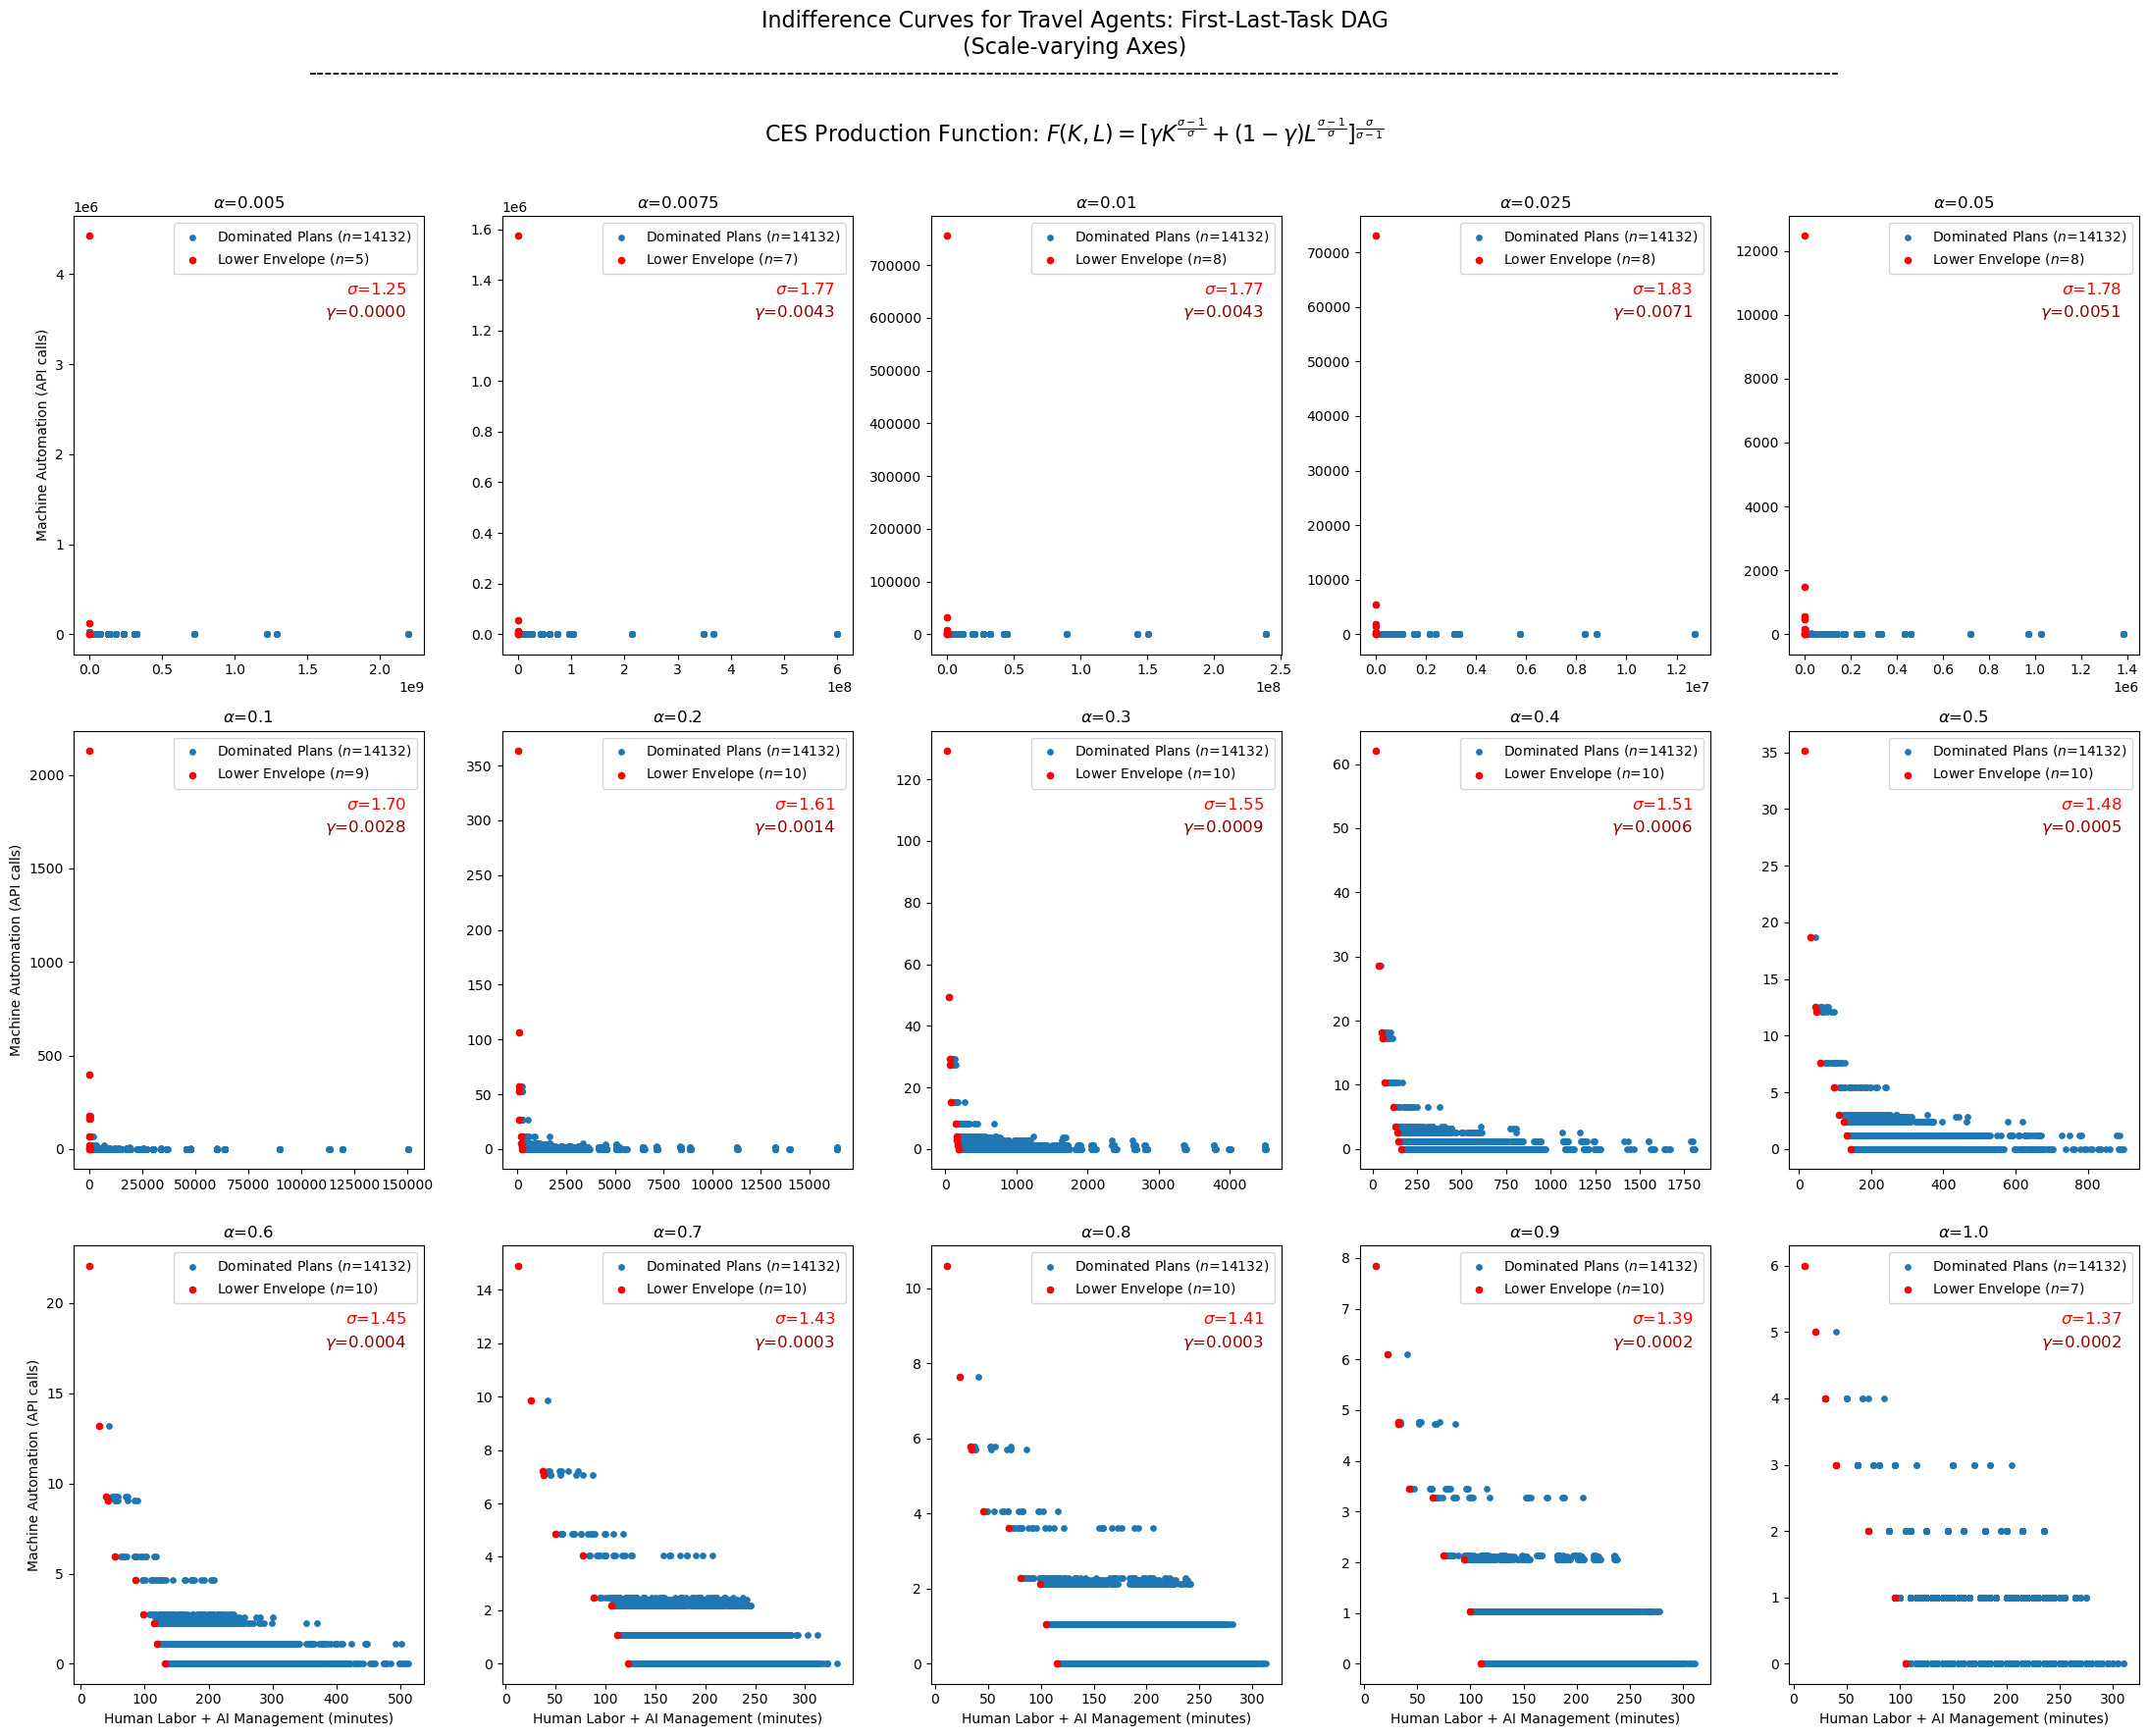

In [ ]:
# Plot version 1a: no scaling with lower envelope points colored red - linear axes

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(22, 18))

# Iterate over each subplot position and add a plot
for i in range(3): 
    for j in range(5): 
        alpha_index = (i % 5) * 5 + j
        my_alpha = alpha_list[alpha_index]

        # Plot all execution plans for given alpha
        my_alpha_indiff_df = indiff_df[indiff_df['alpha']==my_alpha]
        axs[i, j].scatter(my_alpha_indiff_df.labor_cost, my_alpha_indiff_df.automation_cost, 
                          s=15, 
                          label=f'Dominated Plans (' + r'$n$' + f'={my_alpha_indiff_df.shape[0]})')
        
        # Plot lower envelope points in red
        my_alpha_lower_envelope_df = lower_envelope_df[lower_envelope_df['alpha']==my_alpha]
        axs[i, j].scatter(my_alpha_lower_envelope_df.labor_cost, my_alpha_lower_envelope_df.automation_cost, 
                          s=20, 
                          color='red', 
                          label='Lower Envelope (' + r'$n$' + f'={my_alpha_lower_envelope_df.shape[0]})')
        
        # Add elasticity and labor share for current alpha
        my_alpha_sigma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'sigma'].values[0]
        my_alpha_gamma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'gamma'].values[0]
        
        sigma_display = r'$\sigma$' + f'={my_alpha_sigma:.2f}'
        gamma_display = r'$\gamma$' + f'={my_alpha_gamma:.4f}'
        axs[i, j].text(0.95, 0.85, sigma_display, transform=axs[i, j].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='red')
        axs[i, j].text(0.95, 0.8, gamma_display, transform=axs[i, j].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='darkred')
        
        # other plot aesthetics
        axs[i, j].title.set_text(r'$\alpha$' + f'={np.round(my_alpha,4)}')
        if i == 2:
              axs[i, j].set_xlabel('Human Labor + AI Management (minutes)')
        if j == 0:
              axs[i, j].set_ylabel('Machine Automation (API calls)')
        axs[i, j].legend(loc = 'upper right')

fig.suptitle(f'Indifference Curves for {plot_title_occupation} DAG\n' +
             '(Scale-varying Axes)' +
             '\n' + 
            '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n' + 
             r'CES Production Function: $F(K,L) = [\gamma K^{\frac{\sigma-1}{\sigma}} + (1-\gamma) L^{\frac{\sigma-1}{\sigma}}]^{\frac{\sigma}{\sigma-1}} $' + 
             '\n' +
             '\n',
             fontsize=16)

plt.tight_layout()

# Save the plot
# plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_linear_FLT.png', dpi=300)
plt.savefig(f'{occupation}_indiffCurve_linear_FLT.png', dpi=300)

# Show plot
plt.show()

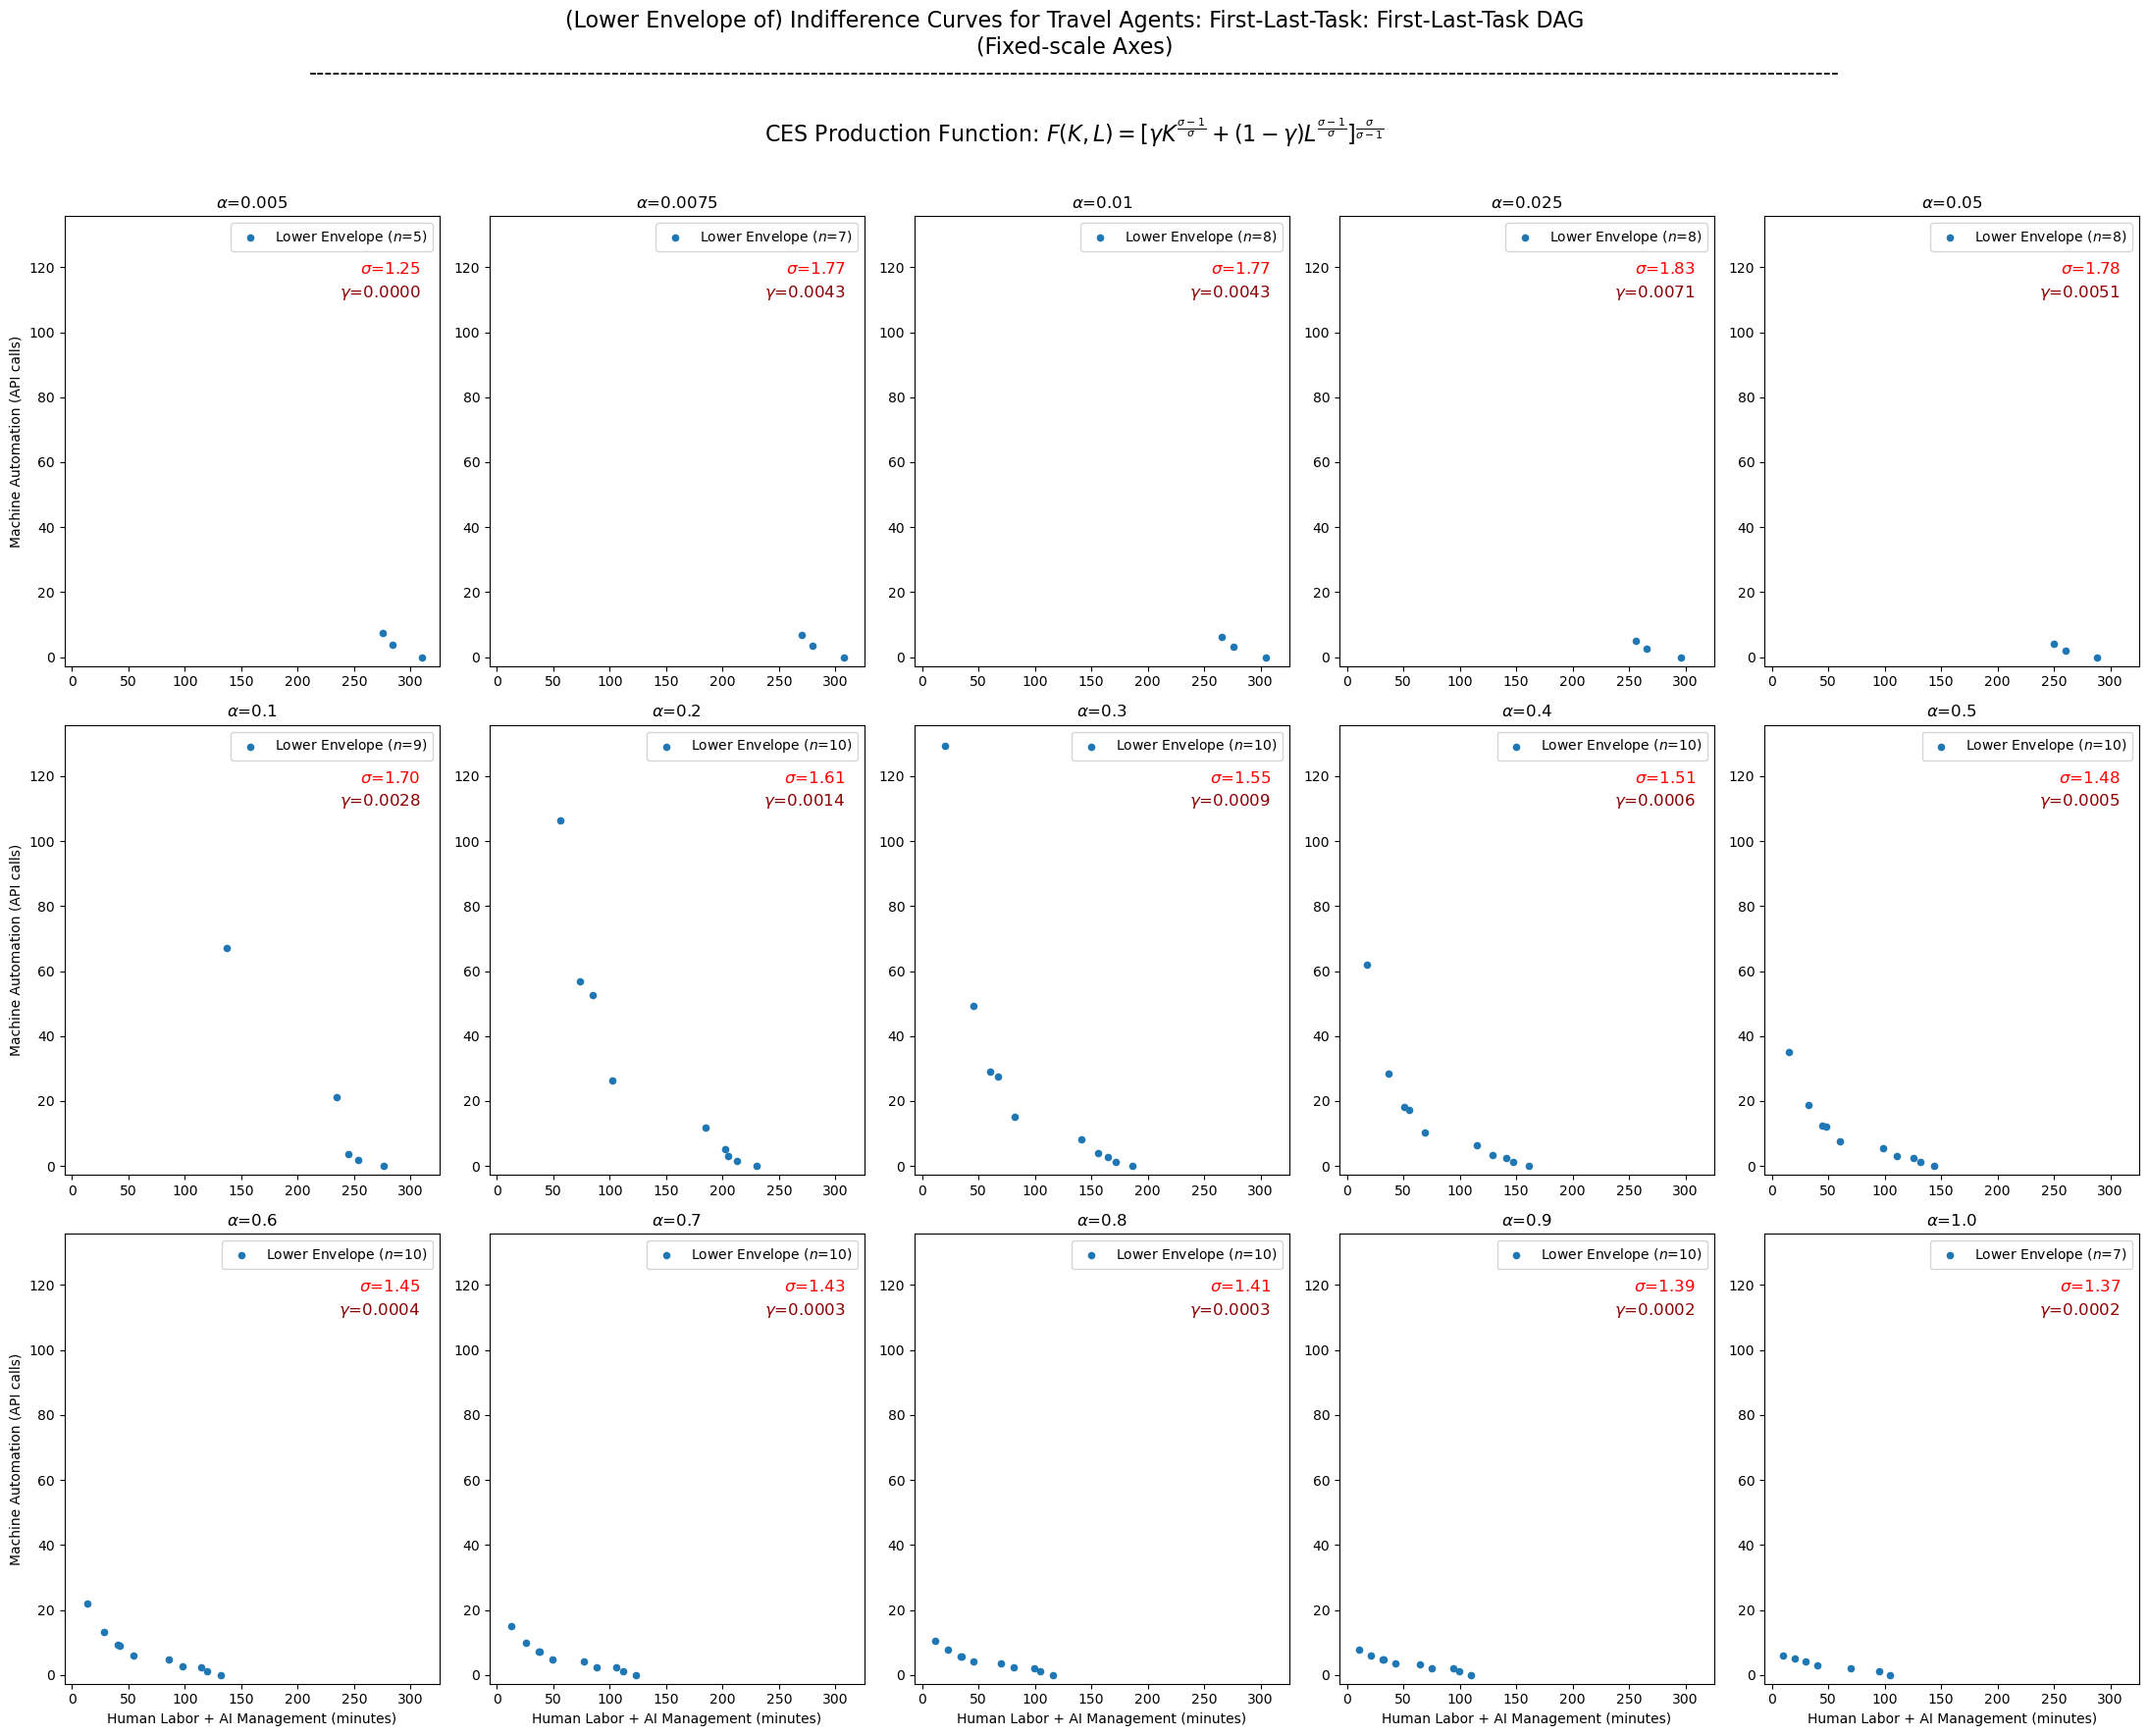

In [ ]:
# Plot version 2a: scaling with only lower envelope points - linear axes

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(22, 18))

# Iterate over each subplot position and add a plot
for i in range(3): 
    for j in range(5): 
        alpha_index = (i % 5) * 5 + j
        my_alpha = alpha_list[alpha_index]

        # Plot lower envelope points in red
        my_alpha_lower_envelope_df = lower_envelope_df[lower_envelope_df['alpha']==my_alpha]
        axs[i, j].scatter(my_alpha_lower_envelope_df.labor_cost, my_alpha_lower_envelope_df.automation_cost, 
                          s=20, 
                          label='Lower Envelope (' + r'$n$' + f'={my_alpha_lower_envelope_df.shape[0]})')
        
        # Add elasticity and labor share for current alpha
        my_alpha_sigma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'sigma'].values[0]
        my_alpha_gamma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'gamma'].values[0]
        
        sigma_display = r'$\sigma$' + f'={my_alpha_sigma:.2f}'
        gamma_display = r'$\gamma$' + f'={my_alpha_gamma:.4f}'
        axs[i, j].text(0.95, 0.9, sigma_display, transform=axs[i, j].transAxes, fontsize=12, 
                       verticalalignment='top', horizontalalignment='right', color='red')
        axs[i, j].text(0.95, 0.85, gamma_display, transform=axs[i, j].transAxes, fontsize=12, 
                       verticalalignment='top', horizontalalignment='right', color='darkred')
        
        # other plot aesthetics
        axs[i, j].title.set_text(r'$\alpha$' + f'={np.round(my_alpha,4)}')
        if i == 2:
              axs[i, j].set_xlabel('Human Labor + AI Management (minutes)')
        if j == 0:
              axs[i, j].set_ylabel('Machine Automation (API calls)')
        axs[i, j].legend(loc = 'upper right')

        # set x and y limits
        xh = lower_envelope_df[lower_envelope_df.alpha==alpha_list[0]]['labor_cost'].max() * 1.05
        xl = - xh / 50
        yh = lower_envelope_df[lower_envelope_df.alpha==0.3]['automation_cost'].max() * 1.05
        yl = - yh / 50
        
        axs[i, j].set_xlim(xl, xh)
        axs[i, j].set_ylim(yl, yh)

fig.suptitle(f'(Lower Envelope of) Indifference Curves for {plot_title_occupation}: First-Last-Task DAG\n' +
             '(Fixed-scale Axes)' +
             '\n' + 
            '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n' + 
             r'CES Production Function: $F(K,L) = [\gamma K^{\frac{\sigma-1}{\sigma}} + (1-\gamma) L^{\frac{\sigma-1}{\sigma}}]^{\frac{\sigma}{\sigma-1}} $' + 
             '\n' +
             '\n',
             fontsize=16)

plt.tight_layout()

# Save the plot
# plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_lowerEnv_linear_FLT.png', dpi=300)
plt.savefig(f'{occupation}_indiffCurve_lowerEnv_linear_FLT.png', dpi=300)

# Show plot
plt.show()

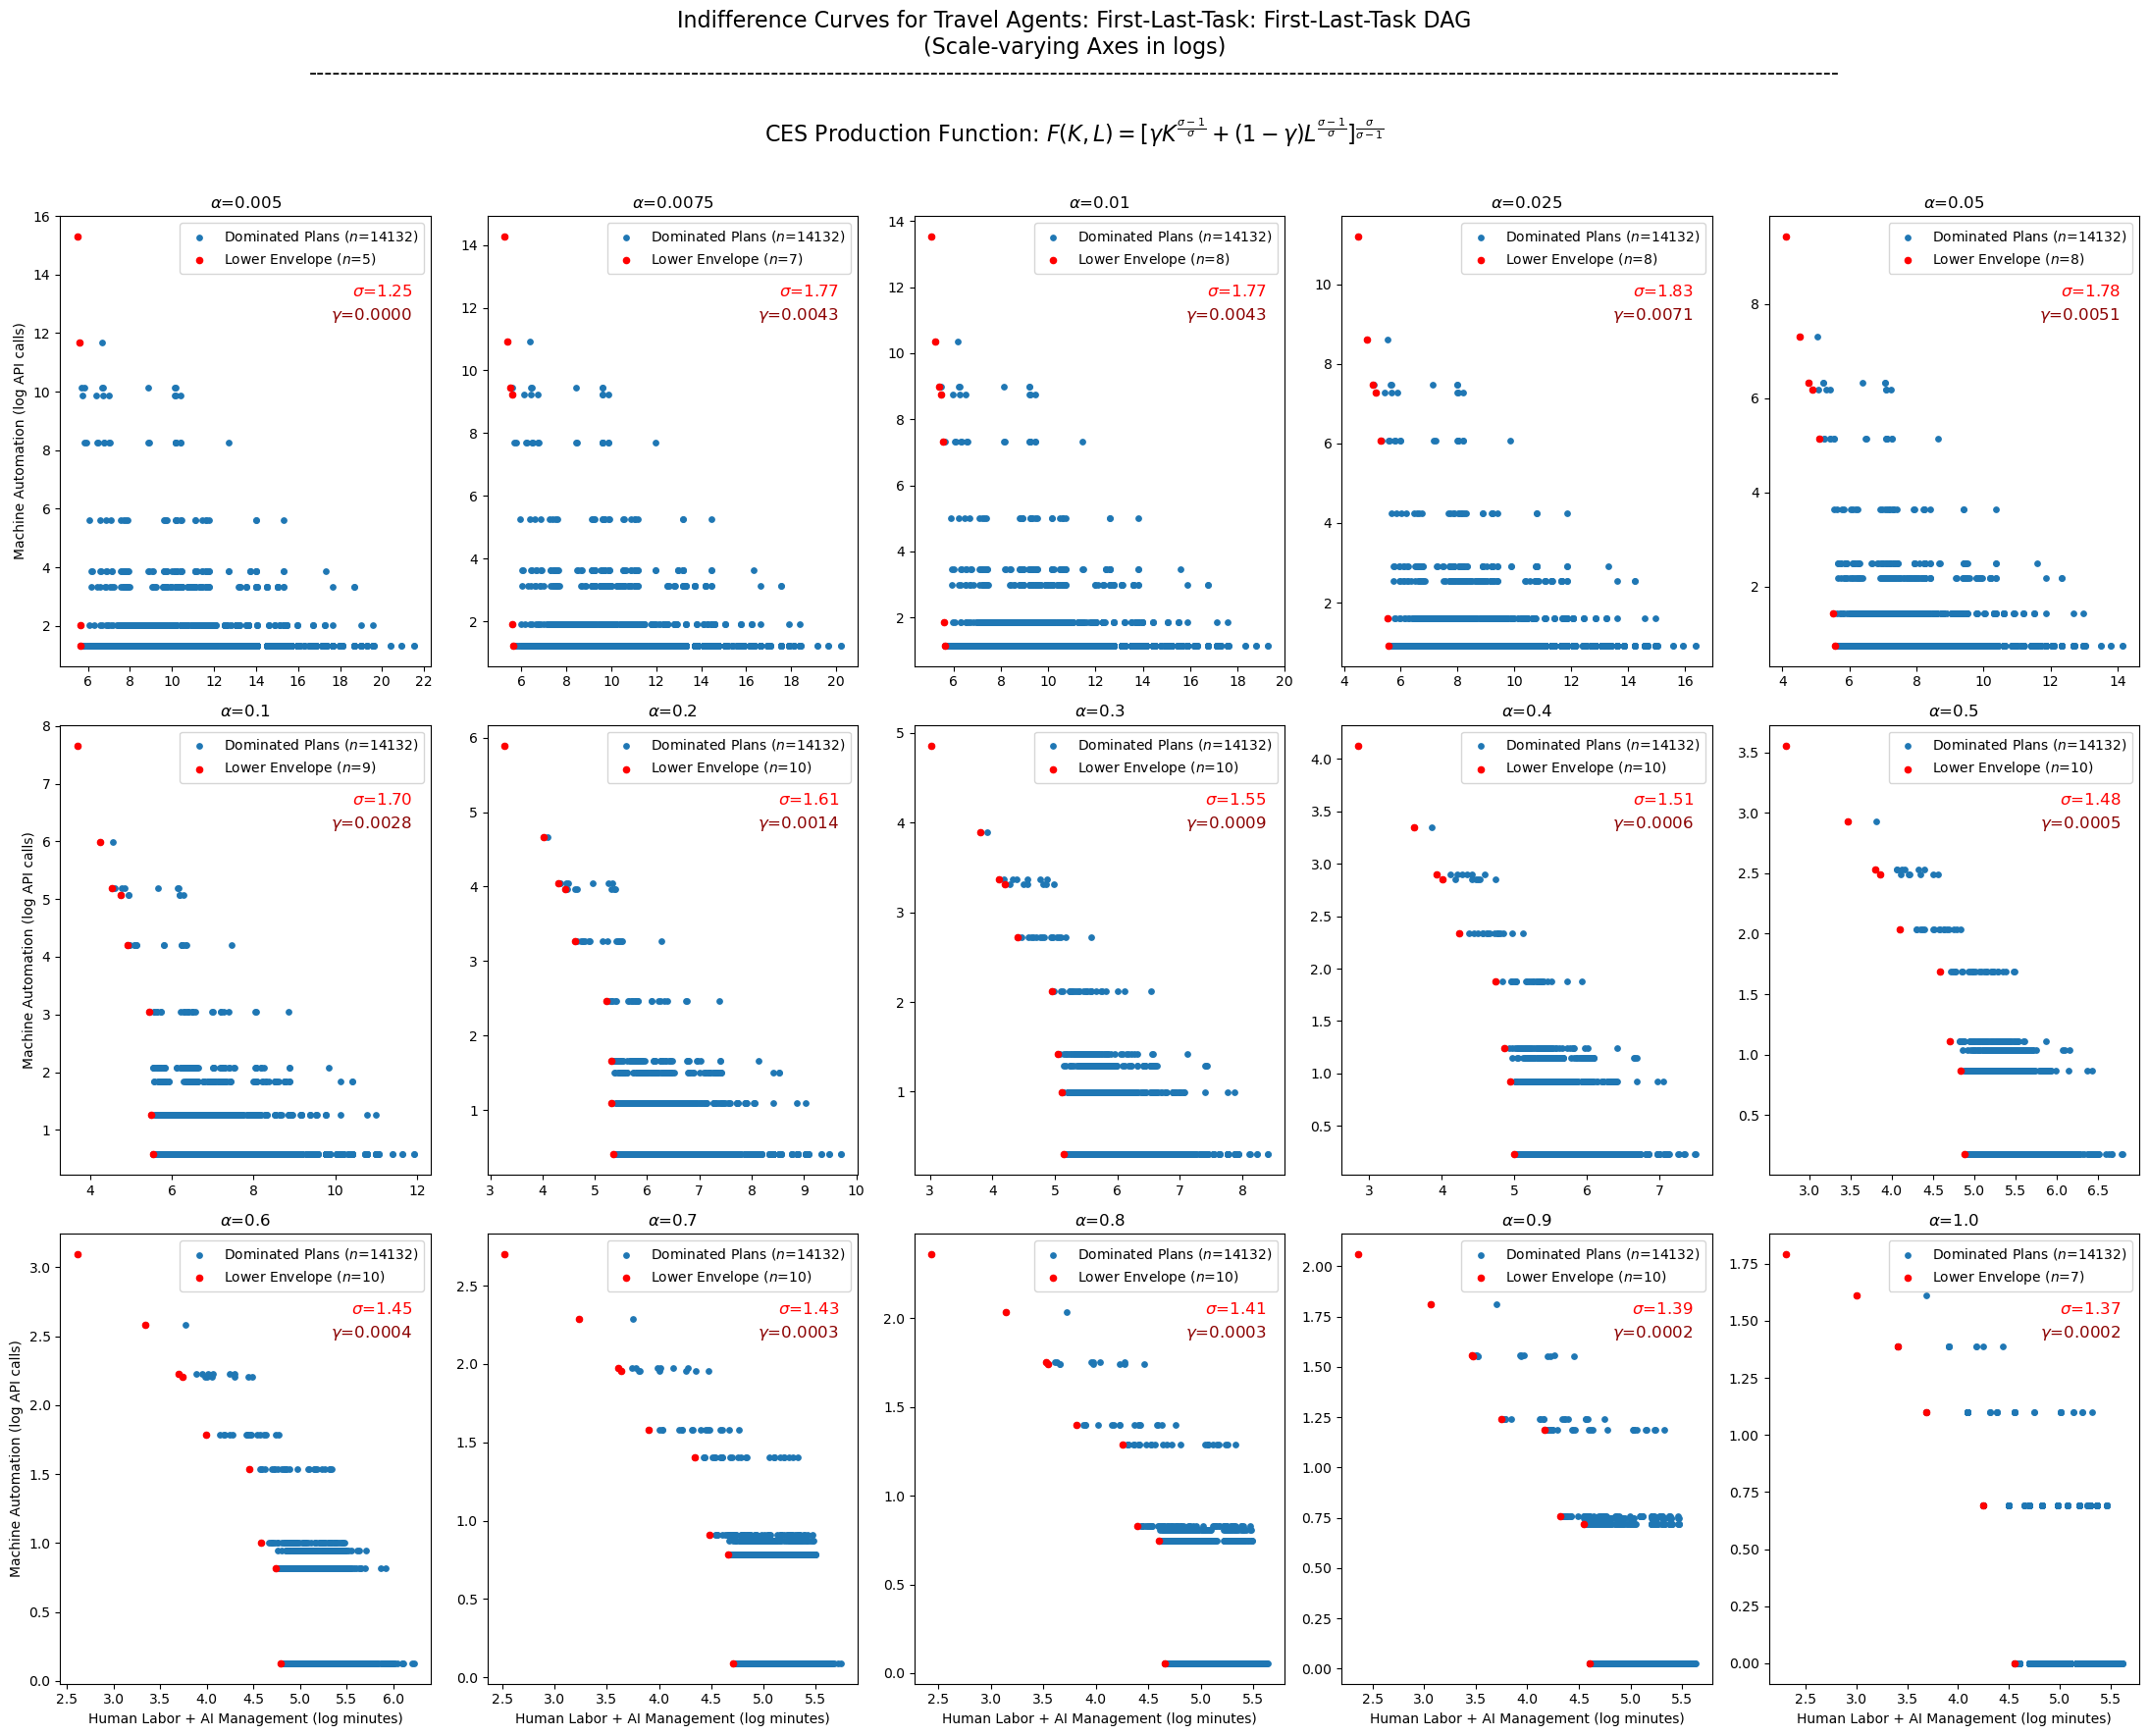

In [ ]:
# Plot version 1b: no scaling with lower envelope points colored red - log axes

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(22, 18))

# Iterate over each subplot position and add a plot
for i in range(3): 
    for j in range(5): 
        alpha_index = (i % 5) * 5 + j
        my_alpha = alpha_list[alpha_index]

        # Plot all execution plans for given alpha
        my_alpha_indiff_df = indiff_df[indiff_df['alpha']==my_alpha]

        # convert scale to log
        my_alpha_indiff_df['labor_cost'] = np.log(my_alpha_indiff_df['labor_cost'])
        my_alpha_indiff_df['automation_cost'] = np.log(my_alpha_indiff_df['automation_cost'])

        axs[i, j].scatter(my_alpha_indiff_df.labor_cost, my_alpha_indiff_df.automation_cost, 
                          s=15, 
                          label=f'Dominated Plans (' + r'$n$' + f'={my_alpha_indiff_df.shape[0]})')
        
        # Plot lower envelope points in red
        my_alpha_lower_envelope_df = lower_envelope_df[lower_envelope_df['alpha']==my_alpha]

        # convert scale to log
        my_alpha_lower_envelope_df['labor_cost'] = np.log(my_alpha_lower_envelope_df['labor_cost'])
        my_alpha_lower_envelope_df['automation_cost'] = np.log(my_alpha_lower_envelope_df['automation_cost'])

        axs[i, j].scatter(my_alpha_lower_envelope_df.labor_cost, my_alpha_lower_envelope_df.automation_cost, 
                          s=20, 
                          color='red', 
                          label='Lower Envelope (' + r'$n$' + f'={my_alpha_lower_envelope_df.shape[0]})')
        
        # Add elasticity and labor share for current alpha
        my_alpha_sigma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'sigma'].values[0]
        my_alpha_gamma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'gamma'].values[0]
        
        sigma_display = r'$\sigma$' + f'={my_alpha_sigma:.2f}'
        gamma_display = r'$\gamma$' + f'={my_alpha_gamma:.4f}'
        axs[i, j].text(0.95, 0.85, sigma_display, transform=axs[i, j].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='red')
        axs[i, j].text(0.95, 0.8, gamma_display, transform=axs[i, j].transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', color='darkred')
        
        # other plot aesthetics
        axs[i, j].title.set_text(r'$\alpha$' + f'={np.round(my_alpha,4)}')
        if i == 2:
              axs[i, j].set_xlabel('Human Labor + AI Management (log minutes)')
        if j == 0:
              axs[i, j].set_ylabel('Machine Automation (log API calls)')
        axs[i, j].legend(loc = 'upper right')

fig.suptitle(f'Indifference Curves for {plot_title_occupation}: First-Last-Task DAG\n' +
             '(Scale-varying Axes in logs)' +
             '\n' + 
            '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n' + 
             r'CES Production Function: $F(K,L) = [\gamma K^{\frac{\sigma-1}{\sigma}} + (1-\gamma) L^{\frac{\sigma-1}{\sigma}}]^{\frac{\sigma}{\sigma-1}} $' + 
             '\n' +
             '\n',
             fontsize=16)

plt.tight_layout()

# Save the plot
# plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_log_FLT.png', dpi=300)
plt.savefig(f'{occupation}_indiffCurve_log_FLT.png', dpi=300)

# Show plot
plt.show()

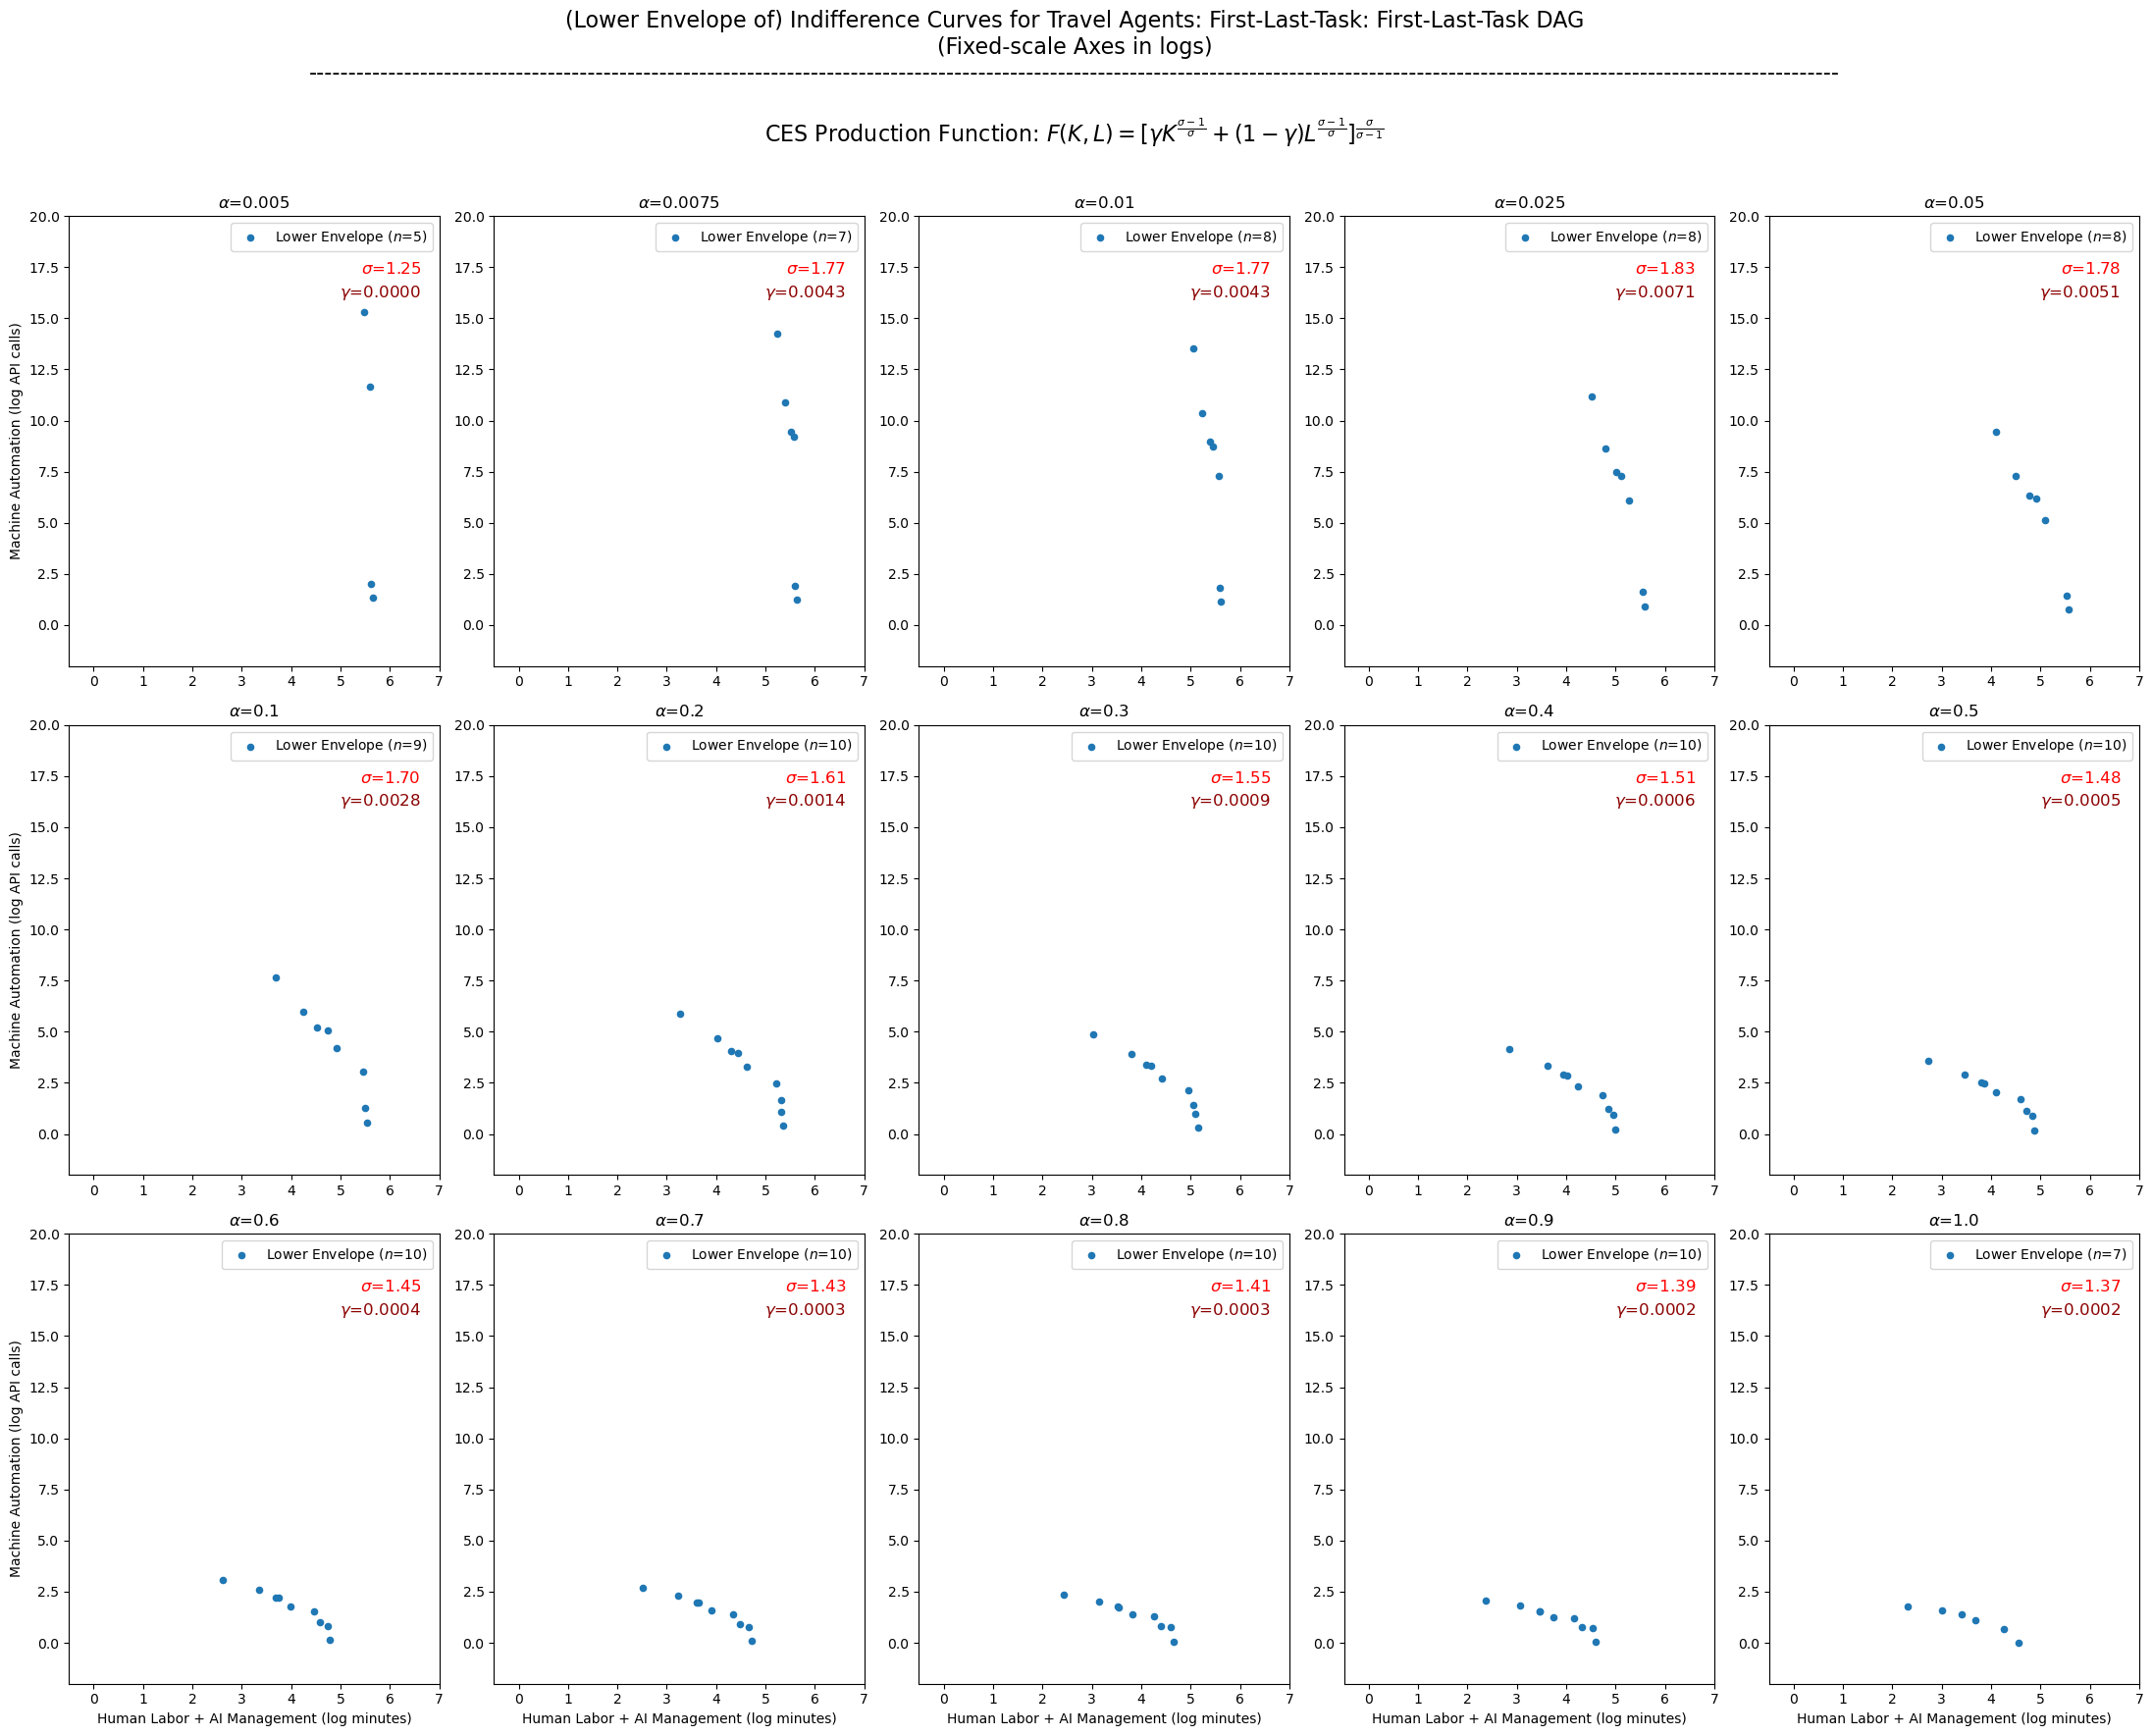

In [ ]:
# Plot version 2a: scaling with only lower envelope points - log axes

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(22, 18))

# Iterate over each subplot position and add a plot
for i in range(3): 
    for j in range(5): 
        alpha_index = (i % 5) * 5 + j
        my_alpha = alpha_list[alpha_index]

        # Plot lower envelope points in red
        my_alpha_lower_envelope_df = lower_envelope_df[lower_envelope_df['alpha']==my_alpha]

        # convert scale to log
        my_alpha_lower_envelope_df['labor_cost'] = np.log(my_alpha_lower_envelope_df['labor_cost'])
        my_alpha_lower_envelope_df['automation_cost'] = np.log(my_alpha_lower_envelope_df['automation_cost'])

        axs[i, j].scatter(my_alpha_lower_envelope_df.labor_cost, my_alpha_lower_envelope_df.automation_cost, 
                          s=20, 
                          label='Lower Envelope (' + r'$n$' + f'={my_alpha_lower_envelope_df.shape[0]})')
        
        # Add elasticity and labor share for current alpha
        my_alpha_sigma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'sigma'].values[0]
        my_alpha_gamma = ETS_df.loc[ETS_df['alpha'] == my_alpha, 'gamma'].values[0]
        
        sigma_display = r'$\sigma$' + f'={my_alpha_sigma:.2f}'
        gamma_display = r'$\gamma$' + f'={my_alpha_gamma:.4f}'
        axs[i, j].text(0.95, 0.9, sigma_display, transform=axs[i, j].transAxes, fontsize=12, 
                       verticalalignment='top', horizontalalignment='right', color='red')
        axs[i, j].text(0.95, 0.85, gamma_display, transform=axs[i, j].transAxes, fontsize=12, 
                       verticalalignment='top', horizontalalignment='right', color='darkred')
        
        # other plot aesthetics
        axs[i, j].title.set_text(r'$\alpha$' + f'={np.round(my_alpha,4)}')
        if i == 2:
              axs[i, j].set_xlabel('Human Labor + AI Management (log minutes)')
        if j == 0:
              axs[i, j].set_ylabel('Machine Automation (log API calls)')
        axs[i, j].legend(loc = 'upper right')

        # set x and y limits
        axs[i, j].set_xlim(-0.5, 7)
        axs[i, j].set_ylim(-2, 20)


fig.suptitle(f'(Lower Envelope of) Indifference Curves for {plot_title_occupation}: First-Last-Task DAG\n' +
             '(Fixed-scale Axes in logs)' +
             '\n' + 
            '------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\n\n' + 
             r'CES Production Function: $F(K,L) = [\gamma K^{\frac{\sigma-1}{\sigma}} + (1-\gamma) L^{\frac{\sigma-1}{\sigma}}]^{\frac{\sigma}{\sigma-1}} $' + 
             '\n' +
             '\n',
             fontsize=16)

plt.tight_layout()

# Save the plot
# plt.savefig(f'{occupation_folder}/indiffCurves/{occupation}_indiffCurves_lowerEnv_log_FLT.png', dpi=300)
plt.savefig(f'{occupation}_indiffCurve_lowerEnv_log_FLT.png', dpi=300)

# Show plot
plt.show()